# Disease Course Mapping with a DEM
## Differential Equation Model of disease progression
Author: Neil Oxtoby, UCL

## Objectives:

This notebook walks you through how to fit a basic Differential Equation Model (DEM) of disease progression using simulated data.

The steps involved:
- Simulate/Load input data
  - e.g., a CSV table of disease features (biomarkers) in a cohort including patients and healthy controls
- Prepare the input data: select a subset of features; perform some basic statistical checks; etc.
- Fit the model
- Perform cross-validation

We add additional steps as didactic exemplars of good practice in data-driven disease progression modelling.

## The set-up

Just install the python dependencies and you're good to go.

In [70]:
# Import some packages
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # default fontsize

## Simulate some data

Text(0.5, 1.0, 'Baseline data')

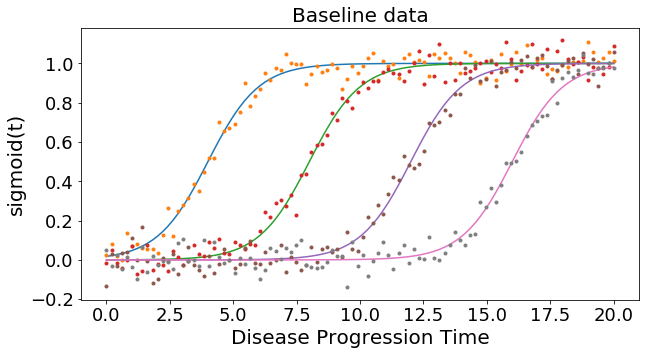

In [198]:
N = 4   # number of events/features
J = 100 # number of patients
N_timepoints_per_individual = 3
noise_scale = 0.05
time_scale = 20

dp = np.linspace(0, time_scale, J)

dp_long = np.reshape(dp,(-1,1))
for kt in range(1,N_timepoints_per_individual):
    next_tp = np.reshape(np.linspace(kt, time_scale+kt, J) + np.random.normal(0, 1/24, dp.size),(-1,1))
    dp_long = np.concatenate(
        (dp_long,next_tp),
        axis=1
    )

def sigmoid(t,a=1,b=-10):
    return 1/(1 + np.exp(-a*(t-b)))

gradients = np.squeeze(np.broadcast_to(1,(1,N)))
onsets    = np.linspace(0,time_scale,N+2)[1:-1]

X = np.empty(shape=(J,N))
X_longitudinal = np.empty(shape=(J,N,N_timepoints_per_individual))
fig,ax = plt.subplots(figsize=(10,5))
for a,b,k in zip(gradients,onsets,range(N)):
    # print('a = %i, b = %i' % (a,b))
    x = sigmoid(t=dp,a=a,b=b)
    #print(x)
    ax.plot(dp, x)
    y = x + np.random.normal(0, noise_scale, x.size)
    X[:,k] = y
    #* Longitudinal data
    X_longitudinal[:,k,:] = sigmoid(t=dp_long,a=a,b=b)
    X_longitudinal[:,k,:] += np.random.normal(0, noise_scale, X_longitudinal[:,k,:].shape)
    
    ax.plot(dp, y,'.')

ax.set_xlabel("Disease Progression Time",fontsize=20) 
ax.set_ylabel("sigmoid(t)",fontsize=20)
ax.set_title("Baseline data",fontsize=20)


In [199]:
# #* Plot longitudinal data
# fig,ax = plt.subplots(figsize=(10,5))
# for kb in range(0,N):
#     ax.plot(np.transpose(dp_long[:,:]), np.transpose(X_longitudinal[:,kb,:]),'.-') #,label=[str(k) for k in range(J)])
# ax.set_xlabel("Disease Progression Time",fontsize=20)
# ax.set_ylabel("sigmoid(t)",fontsize=20)
# # ax.legend()

## Calculate individual rates of change

Simple linear regression

In [123]:
from scipy import stats
dXdt = np.empty(shape=X.shape) #* Individual rate of change
for kb in range(0,N):
    for ki in range(0,J):
        slice_i = ki*N
        y = X_longitudinal[ki,kb,:]
        slope, intercept, r_value, p_value, std_err = stats.linregress(dp_long[k,:], y)
        dXdt[ki,kb] = slope
X_mean = np.mean(X_longitudinal,axis=2)

No handles with labels found to put in legend.


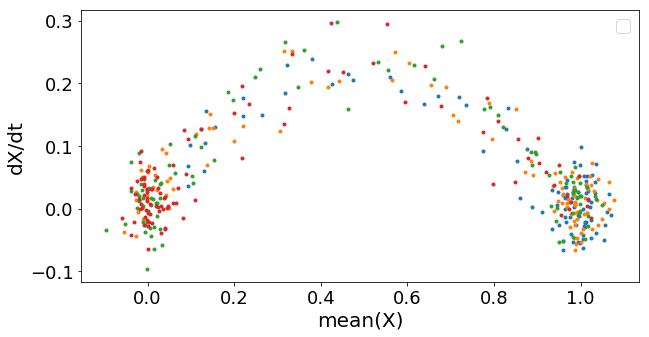

In [204]:
#* Plot differential data
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(X_mean,dXdt,'.')
ax.set_xlabel("mean(X)",fontsize=20)
ax.set_ylabel("dX/dt",fontsize=20)
ax.legend()

## Convert data to Long format for saving to CSV

In [160]:
#* Long format data
t_long    = dp_long.ravel().reshape(-1,1)
X_long_id = np.tile(np.arange(1,J+1).reshape((-1,1)),(1,N_timepoints_per_individual)).ravel().reshape((-1,1))
X_long    = np.empty(shape=(J*N_timepoints_per_individual,N))
for kb in range(N):
    X_long[:,kb]    = X_longitudinal[:,kb,:].ravel() #.reshape((-1,1))

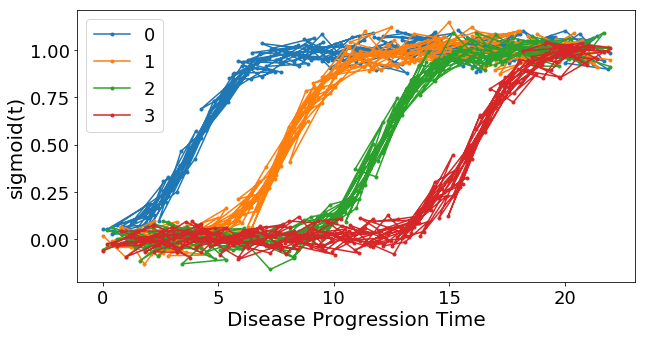

In [165]:
#* Plot long format data to check
fig,ax = plt.subplots(figsize=(10,5))
for kb in range(N):
    ax.plot(t_long, X_long[:,kb],'.-',label=str(kb))
ax.set_xlabel("Disease Progression Time",fontsize=20)
ax.set_ylabel("sigmoid(t)",fontsize=20)
ax.set_title("Short-time longitudinal data",fontsize=20)
ax.legend()

In [194]:
#* Save long format data into dataframe for writing to CSV
import pandas as pd

df_dem_long = pd.DataFrame(data=X_long)
df_dem_long.columns = ['Biomarker-%i' % (k+1) for k in range(0,N)]
df_dem_long['ID'] = X_long_id
df_dem_long['time'] = t_long
print('Adding a diagnosis variable')
df_dem_long['diagnosis'] = df_dem_long['time'].map(lambda x: 1*(x>onsets[-2]) + 2*( (x>onsets[1]) & (x<onsets[-2]) ))
df_dem_long = df_dem_long[['ID','time','diagnosis']+['Biomarker-%i' % (k+1) for k in range(0,N)]]
# print(df_dem_long.groupby('diagnosis').describe())

df_dem_long.to_csv('simulated_data-raw.csv')

df_dem = pd.DataFrame(data = {'ID':np.arange(1,J+1)})
for kb in range(0,N):
    kb_label = 'Biomarker-%i' % (kb+1)
    df_dem[kb_label+'-mean'] = X_mean[:,kb]
    df_dem[kb_label+'-slope']      = dXdt[:,kb]
df_dem.to_csv('simulated_data-differential.csv')
df_dem.head()

,ID,Biomarker-1-mean,Biomarker-1-slope,Biomarker-2-mean,Biomarker-2-slope,Biomarker-3-mean,Biomarker-3-slope,Biomarker-4-mean,Biomarker-4-slope
0,1,0.093242,0.067578,-0.021474,-0.005500,-0.018541,0.020607,-0.028100,0.023426
1,2,0.093586,0.036038,0.004163,0.068617,0.015946,-0.029438,0.022150,0.050231
2,3,0.098976,0.101974,0.021308,0.029288,0.005386,-0.031654,-0.009256,0.021059
3,4,0.130049,0.060580,-0.027218,0.013826,0.011533,0.015843,-0.007273,0.039638
4,5,0.156904,0.130078,-0.010256,-0.015958,-0.019375,0.011467,0.009480,-0.023275


# FIXME: Add additional steps

1. Prepare data for fitting
2. Fit
3. Integrate and anchor by diagnosis
4. Combine curves

# FIXME: Remove EBM stuff and replace with DEM

## Didactic step: Look at the data

1. Visual: look at the histograms of patients and controls
2. Statistical tests: use null hypothesis statistical tests of "differences" to select features
  - Loosely speaking, a significant difference suggests presence of "disease signal" (patient measurements are "different" to controls measurements) in a biomarker

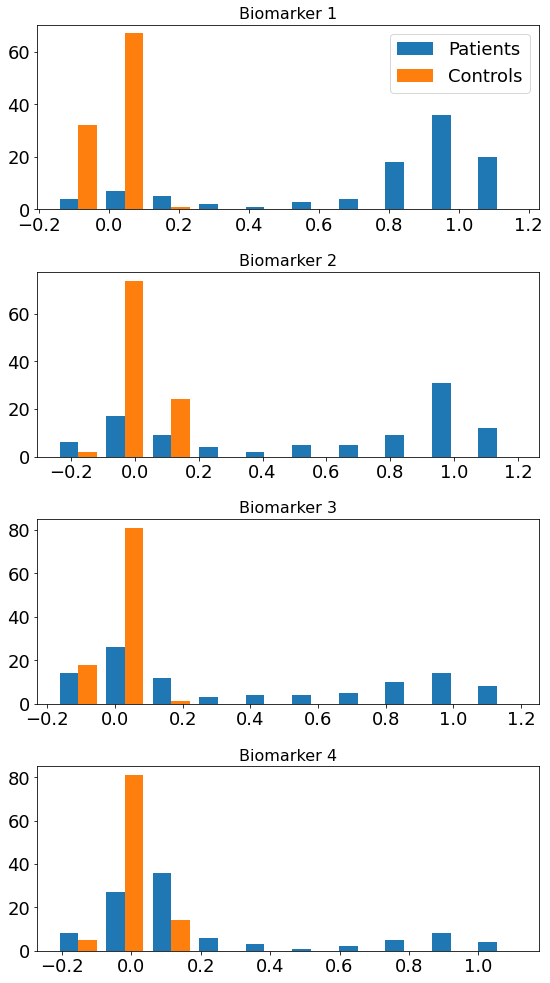

In [4]:
#* 1. Histograms
fig,ax = plt.subplots(N,1,figsize=(8,14))
for k in range(N):
    ax[k].hist([ X[:,k],X_controls[:,k]],label=['Patients','Controls'])
    ax[k].set_title('Biomarker %i' % (k+1),fontsize=16)
ax[0].legend()
fig.tight_layout()

## Basic statistical tests

- Effect size: (difference in medians) / ("width" of controls distribution)

- Mann-Whitney U test (quoting Wikipedia):<br/>
> a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

In [5]:
#* 2. Basic statistics
# I use a nonparametric test because it works regardless of the data distributions 
# (some tests assume some level of Gaussianity)
print('Mann Whitney U test')

for k in range(N):
    x_c = X_controls[:,k]
    x_p = X[:,k]
    effect_size = np.absolute(np.median(x_p)-np.median(x_c))/stats.median_abs_deviation(x_c)
    u,p = stats.mannwhitneyu(x_c,x_p)
    print('Biomarker %i\n - effect size = %.3g\n - u = %i, p = %.2g' % (k+1,effect_size,u,p))

Mann Whitney U test
Biomarker 1
 - effect size = 25.6
 - u = 563, p = 1.1e-27
Biomarker 2
 - effect size = 21.4
 - u = 1774, p = 1.6e-15
Biomarker 3
 - effect size = 6.45
 - u = 2026, p = 1.9e-13
Biomarker 4
 - effect size = 2.79
 - u = 2422, p = 1.5e-10


## Prepare data for fitting

Data matrix `X` has `M` individuals (patients, controls, prodromal/at-risk individuals) and `N` biomarkers/events

# FIXME: replace with DEM version
## Patient staging utility

Concept: align individuals to the model

Method (see [Oxtoby et al, Brain 2018](https://doi.org/10.1093/brain/awy050)): compare data from each individual (patients/controls/at-risk) with the model and calculate a `p(event)` vector, then assign the most likely stage according to the accumulation of disease events

In [15]:
#* Define the DEM staging function
def ebm_staging(x,mixtures,samples):
    """
    Given a trained EBM (mixture_models,mcmc_samples), and correctly-formatted data, stage the data
    NOTE: To use CV-EBMs, you'll need to call this for each fold, then combine.
    Author: Neil P Oxtoby, UCL, September 2018
    """
    if type(mixtures[0]) is list:
        #* List of mixture models from cross-validation / bootstrapping
        n_cv = len(mixtures)
        prob_mat = []
        stages = []
        stage_likelihoods = []
        stages_expected = []
        for k in range(n_cv):
            #* Stage the data
            prob_mat.append(get_prob_mat(x, mixtures[k]))
            stages_k, stage_likelihoods_k = samples[k][0].stage_data(prob_mat[k])
            stages.append(stages_k)
            stage_likelihoods.append(stage_likelihoods_k)
            #* Average (expectation value) stage
            stages_expected_k = np.ndarray(shape=stages_k.shape)
            for kk in range(stages_expected_k.shape[0]):
                stages_expected_k[kk] = np.sum(stage_likelihoods_k[kk,:]*np.arange(1,stage_likelihoods_k.shape[1]+1,1))/np.sum(stage_likelihoods_k[kk,:]) - 1
            stages_expected.append(stages_expected_k)
    else:
        #* Stage the data
        prob_mat = get_prob_mat(x, mixtures)
        if type(samples[0]) is list:
            n_bs = len(samples)
            stages = []
            stage_likelihoods = []
            stages_expected = []
            for k in range(n_bs):
                #* Stage the data
                stages_k, stage_likelihoods_k = samples[k][0].stage_data(prob_mat)
                stages.append(stages_k)
                stage_likelihoods.append(stage_likelihoods_k)
                #* Average (expectation value) stage
                stages_expected_k = np.ndarray(shape=stages_k.shape)
                for kk in range(stages_expected_k.shape[0]):
                    stages_expected_k[kk] = np.sum(stage_likelihoods_k[kk,:]*np.arange(1,stage_likelihoods_k.shape[1]+1,1))/np.sum(stage_likelihoods_k[kk,:]) - 1
                stages_expected.append(stages_expected_k)
        else:
            stages, stage_likelihoods = samples[0].stage_data(prob_mat)
            #* Average (expectation value) stage
            stages_expected = np.ndarray(shape=stages.shape)
            for k in range(stages_expected.shape[0]):
                stages_expected[k] = np.sum(stage_likelihoods[k,:]*np.arange(1,stage_likelihoods.shape[1]+1,1))/np.sum(stage_likelihoods[k,:]) - 1
    # #* Average (expectation value) stage
    # stages_expected_n = np.sum(stage_likelihoods,axis=1)
    # stages_expected_ = np.average(stage_likelihoods_long_ml,axis=1,weights=np.arange(1,stage_likelihoods_long_ml.shape[1]+1,1))
    # stages_expected_ = stages_expected_/stages_expected_n
    
    return prob_mat, stages, stage_likelihoods, stages_expected


In [16]:
#* Staging
# df_staging = df_EBM.copy()
# staging_columns = ['RID','VISCODE',dx_column,'Years_bl']+e
# df_staging = df_staging[staging_columns].copy()
# x_long = df_staging[e].values
# df_staging['Fraction missing data'] = np.sum(np.isnan(x_long),axis=1)/x_long.shape[1]
# stage_column = "Model stage"

#* Maximum-likelihood model stage
prob_mat_ml, stages_long_ml, stage_likelihoods_long_ml, stages_long_ml_expected = ebm_staging(
    x=X,
    mixtures=kde_mixtures,
    samples=mcmc_samples
)
stages_long = stages_long_ml

### Plot a staging histogram

Density of individuals against time

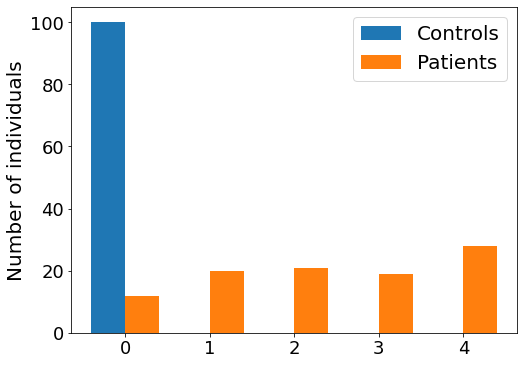

In [17]:
fig, ax = plt.subplots(figsize=(8,6))

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

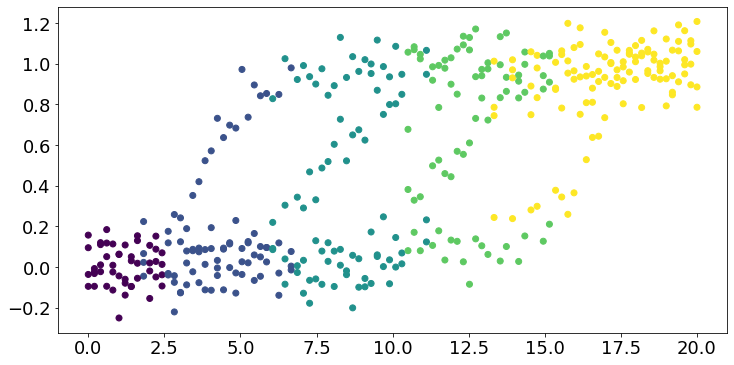

## (FIXME) Cross-validation

Generalizability/robustness of a model can be quantified by **testing** the model on independent data, i.e., data not included when training the model.

Cross-validation does this by splitting the available data into train/test sets.

### k-fold cross-validation

Splitting a dataset into `k` "folds" enables calculation of model performance statistics (e.g., mean, standard deviation) over `k` test sets, using the other `k-1` folds to train the model each time.

It is common to use `k=10`, which amounts to using 90% of your data to train and 10% to test.

This process can be repeated multiple times using different random partitions (splits) into folds.


![image_kfold_cv](K-fold_cross_validation_EN.png)

By Gufosowa - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=82298768
